## MNIST picture generation using Generative Adversarial Networks 

In this notebook I will be demostrating the famous generative adversarial networks. I will be generating pictures from MNIST dataset using GAN. 

### Basic Imports 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Loading the data 

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/",one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


### Ploting a sample image 

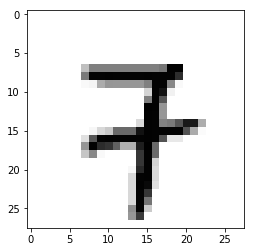

In [4]:
plt.imshow(mnist.train.images[14].reshape(28,28),cmap='Greys')

### Setting up GAN

### Generator Network

In [5]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden_1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        # I am just manually creating the leaky relu activation function 
        alpha = 0.01
        hidden_1 = tf.maximum(alpha*hidden_1,hidden_1)
        
        hidden_2 = tf.layers.dense(inputs=hidden_1,units=128)
        
        hidden_2 = tf.maximum(alpha*hidden_2,hidden_2)
        
        output = tf.layers.dense(hidden_2,units=784,activation=tf.nn.tanh)
        return output

### Discriminator Network

In [6]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden_1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        # Manual leaky relu like above 
        alpha = 0.01
        hidden_1 = tf.maximum(alpha*hidden_1,hidden_1)
        
        hidden_2 = tf.layers.dense(inputs=hidden_1,units=128)
        hidden_2 = tf.maximum(alpha*hidden_2,hidden_2)
        
        logits = tf.layers.dense(hidden_2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [7]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [8]:
Gen = generator(z)

### Discriminator

In [9]:
Dis_out_real, Dis_logits_real = discriminator(real_images)

In [10]:
Dis_out_genrated, Dis_logits_generated = discriminator(Gen,reuse=True)

The discriminator, which is trained on real images is asked to distinguish bewteen the generated images from the generator and the real images. 

### Losses

In [11]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [12]:
Dis_real_loss = loss_func(Dis_logits_real,tf.ones_like(Dis_logits_real)* (0.9))

In [13]:
Dis_genrated_loss = loss_func(Dis_logits_generated,tf.zeros_like(Dis_logits_real))

In [14]:
Dis_loss = Dis_real_loss + Dis_genrated_loss

In [15]:
Gen_loss = loss_func(Dis_logits_generated,tf.ones_like(Dis_logits_generated))

### Optimizers

In [16]:
learning_rate = 0.001

In [17]:
tvars = tf.trainable_variables()

dis_vars = [var for var in tvars if 'dis' in var.name]
gen_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in dis_vars])
print([v.name for v in gen_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [18]:
Dis_trainer = tf.train.AdamOptimizer(learning_rate).minimize(Dis_loss, var_list=dis_vars)
Gen_trainer = tf.train.AdamOptimizer(learning_rate).minimize(Gen_loss, var_list=gen_vars)

### Training

In [19]:
batch_size = 64
epochs = 300
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=gen_vars)

In [20]:
# Save a sample per epoch
samples = []

In [21]:
with tf.Session() as sess:
    
    sess.run(init)
    
    
    for e in range(epochs):
        
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(Dis_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(Gen_trainer, feed_dict={z: batch_z})
        
            
        print("Epoch {} of {} ".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
    saver.save(sess, './gan_mnist_sample_1')

Epoch 1 of 300 
Epoch 2 of 300 
Epoch 3 of 300 
Epoch 4 of 300 
Epoch 5 of 300 
Epoch 6 of 300 
Epoch 7 of 300 
Epoch 8 of 300 
Epoch 9 of 300 
Epoch 10 of 300 
Epoch 11 of 300 
Epoch 12 of 300 
Epoch 13 of 300 
Epoch 14 of 300 
Epoch 15 of 300 
Epoch 16 of 300 
Epoch 17 of 300 
Epoch 18 of 300 
Epoch 19 of 300 
Epoch 20 of 300 
Epoch 21 of 300 
Epoch 22 of 300 
Epoch 23 of 300 
Epoch 24 of 300 
Epoch 25 of 300 
Epoch 26 of 300 
Epoch 27 of 300 
Epoch 28 of 300 
Epoch 29 of 300 
Epoch 30 of 300 
Epoch 31 of 300 
Epoch 32 of 300 
Epoch 33 of 300 
Epoch 34 of 300 
Epoch 35 of 300 
Epoch 36 of 300 
Epoch 37 of 300 
Epoch 38 of 300 
Epoch 39 of 300 
Epoch 40 of 300 
Epoch 41 of 300 
Epoch 42 of 300 
Epoch 43 of 300 
Epoch 44 of 300 
Epoch 45 of 300 
Epoch 46 of 300 
Epoch 47 of 300 
Epoch 48 of 300 
Epoch 49 of 300 
Epoch 50 of 300 
Epoch 51 of 300 
Epoch 52 of 300 
Epoch 53 of 300 
Epoch 54 of 300 
Epoch 55 of 300 
Epoch 56 of 300 
Epoch 57 of 300 
Epoch 58 of 300 
Epoch 59 of 300 
Epoch 

### Generating new Images 

In [22]:
saver = tf.train.Saver(var_list=gen_vars)
new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./gan_mnist_sample_1')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./gan_mnist_sample_1


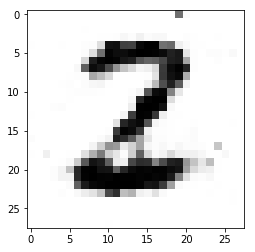

In [24]:
plt.imshow(new_samples[0].reshape(28,28),cmap='Greys') # newly generated sample 

As we can see, the trained GAN does a decent job in generating new 'fake' images. 